## S&P 500 Sharpe vs. Correlation Matrices - Building a dataset for generating stressed/rally/normal scenarios

https://marti.ai/qfin/2020/02/03/sp500-sharpe-vs-corrmats.html

In [1]:
import sys
from random import randint
import pandas as pd
import numpy as np
import fastcluster
from scipy.cluster import hierarchy
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import os

In [2]:
df = pd.read_csv('data/SP500_HistoTimeSeries.csv')
df = df.tail(252*5)
print(len(df))

1260


In [3]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

df.index = df['Date']
del df['Date']
df = df.sort_index()

returns = df.pct_change(periods=1)

In [4]:
dim = 100
tri_a, tri_b = np.triu_indices(dim, k=1)

C:\Users\geril\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


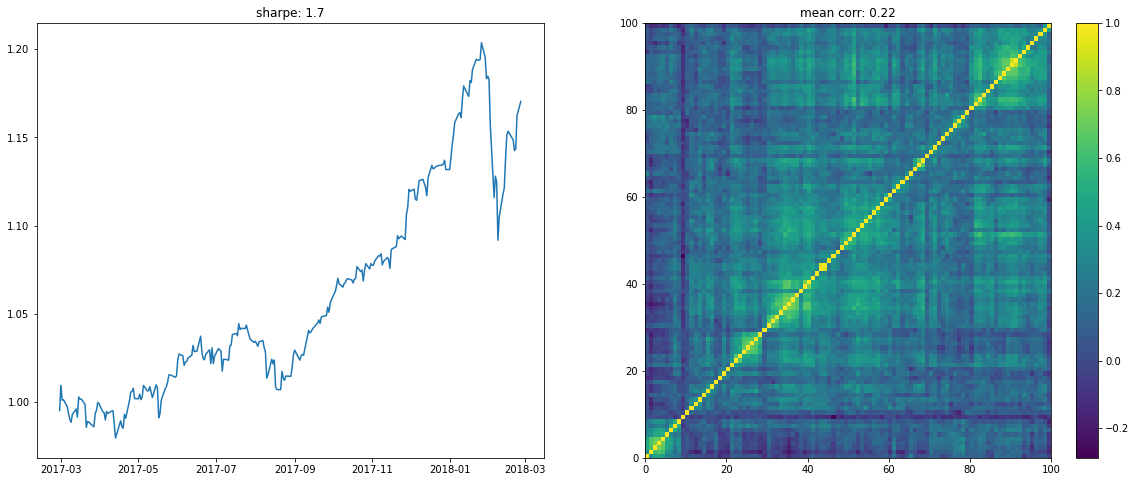

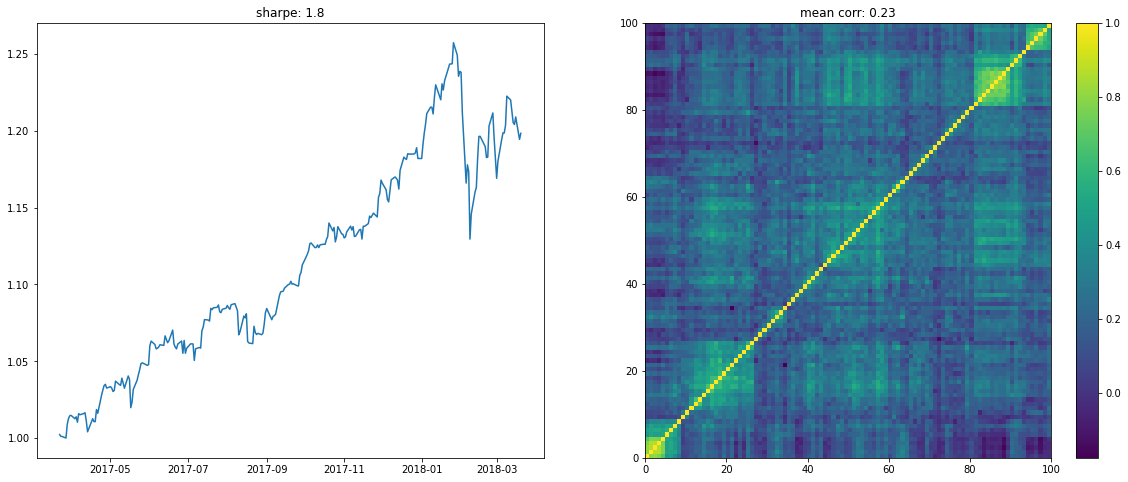

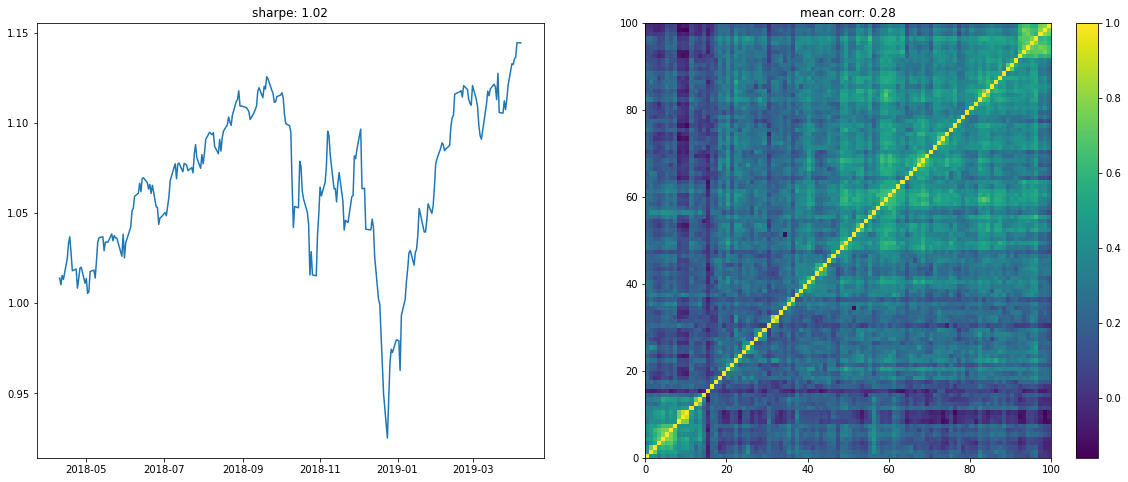

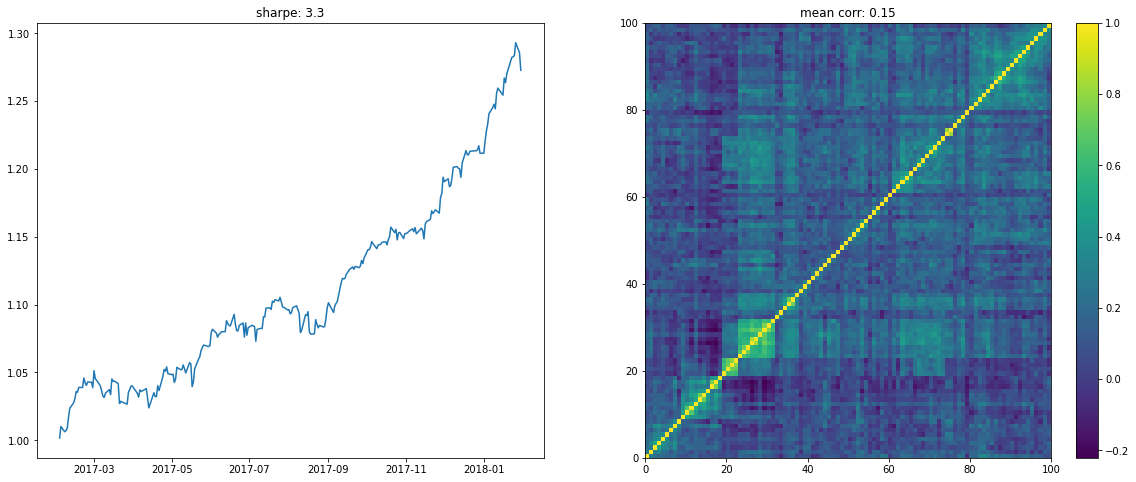

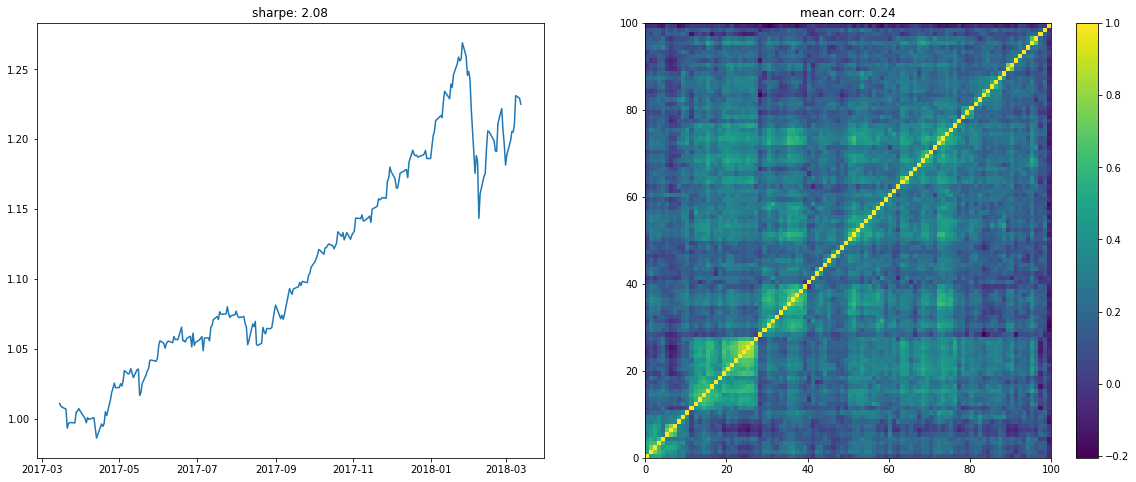

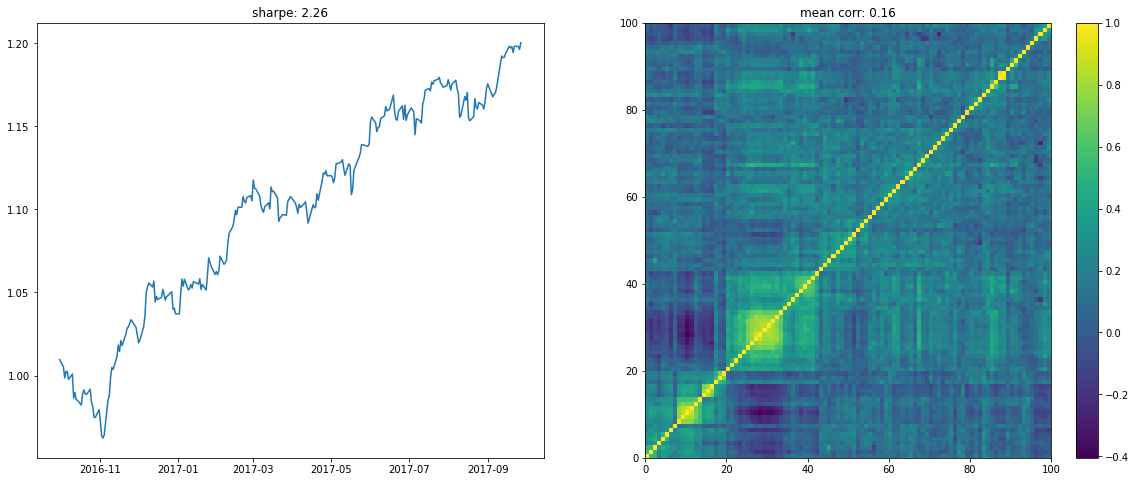

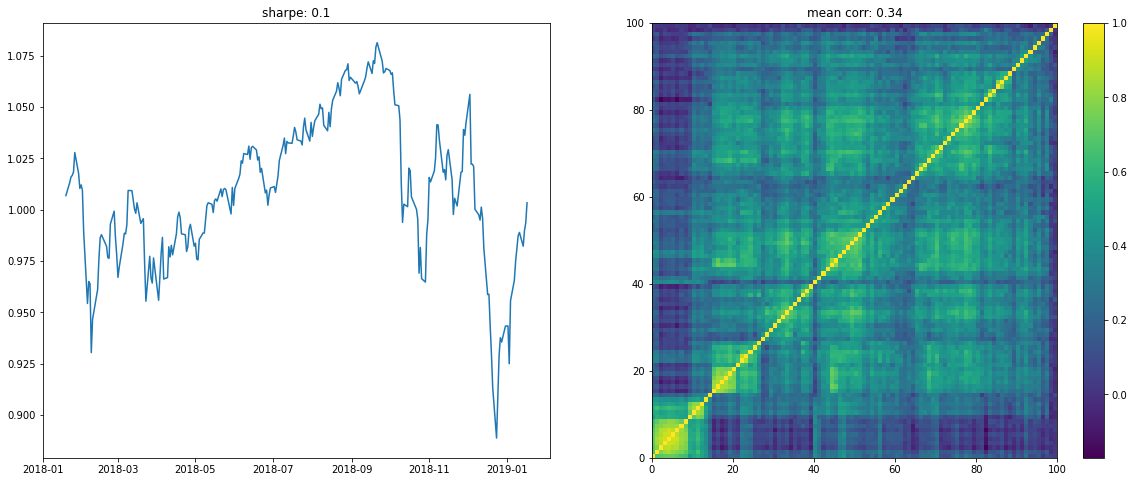

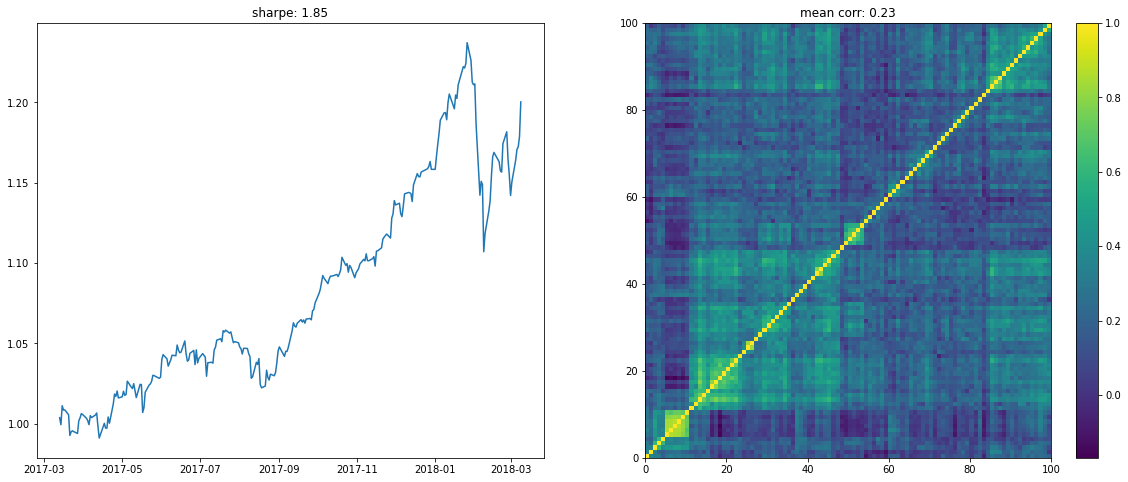

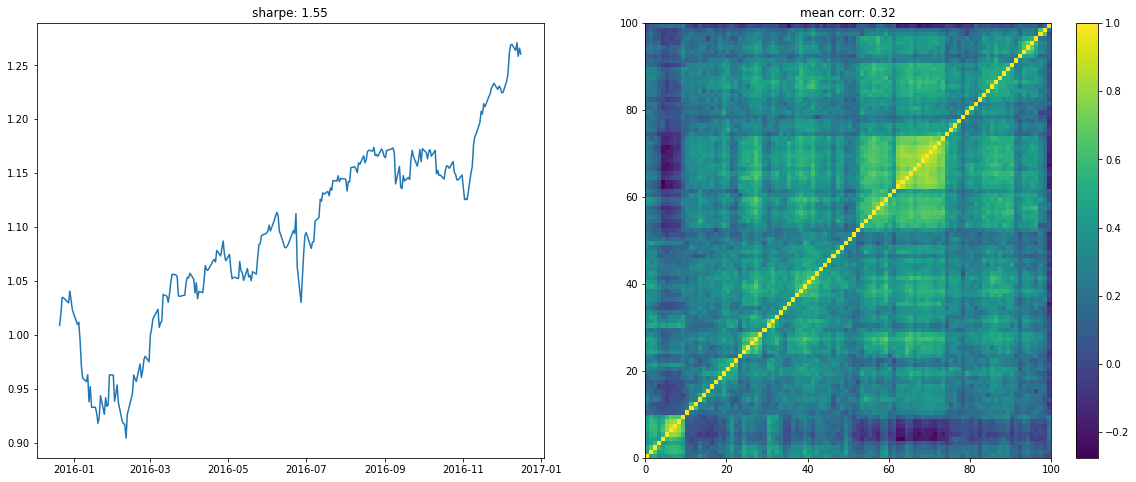

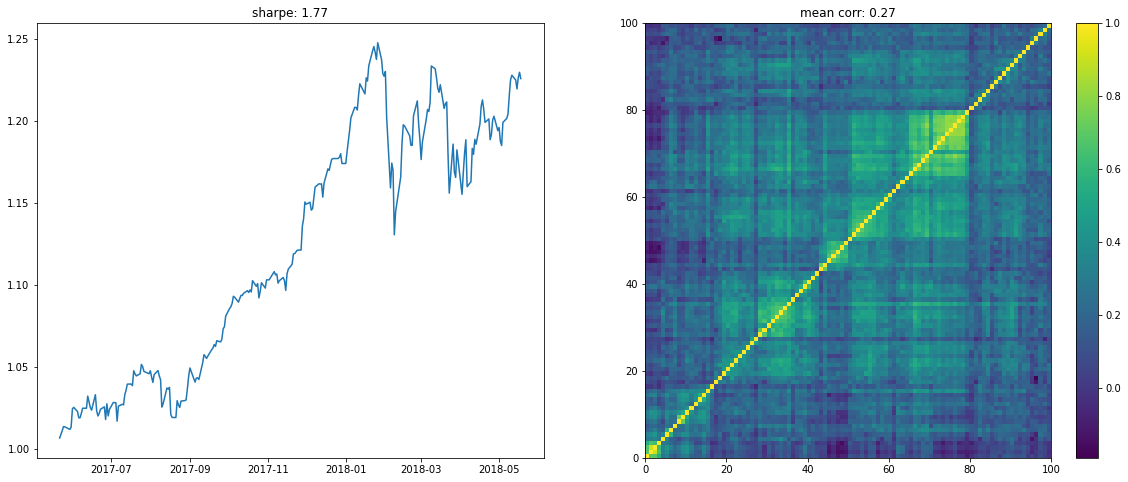

In [5]:
corr_vs_sharpe = []
stressed_mats = []
stressed_count = 0
rally_mats = []
rally_count = 0
normal_mats = []
normal_count = 0
for loop in range(2000):
    try:
        t_idx = randint(0, len(returns) - 252)

        period_returns = returns.iloc[t_idx:(t_idx + 252)]

        rmv = 0
        for col in period_returns.columns:
            if len(period_returns[col].dropna()) < 252:
                rmv += 1
                del period_returns[col]
        rmv, period_returns.shape

        idx = list(np.random.choice(len(period_returns.columns), dim,
                                    replace=False))

        period_returns[period_returns.columns[idx]].dropna().shape

        corr = period_returns[
            period_returns.columns[idx]].dropna().corr().values
        corr.mean()

        mean_return = (period_returns[period_returns.columns[idx]]
                       .dropna()
                       .mean(axis=1)
                       .mean() * 252)
        vol = (period_returns[period_returns.columns[idx]]
               .dropna()
               .mean(axis=1)
               .std() * np.sqrt(252))
        sharpe = mean_return / vol

        dist = 1 - corr
        Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
        permutation = hierarchy.leaves_list(
            hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
        prows = corr[permutation, :]
        ordered_corr = prows[:, permutation]

        corr_vs_sharpe.append([corr.mean(), sharpe])
        
        if sharpe < -0.5:
            stressed_mats.append(ordered_corr)
            np.save('stressed_mats/mat_{}.npy'.format(stressed_count),
                    ordered_corr)
            stressed_count += 1
        elif sharpe > 2:
            rally_mats.append(ordered_corr)
            np.save('rally_mats/mat_{}.npy'.format(rally_count),
                    ordered_corr)
            rally_count += 1
        else:
            normal_mats.append(ordered_corr)
            np.save('normal_mats/mat_{}.npy'.format(normal_count),
                    ordered_corr)
            normal_count += 1

        if loop < 10:
            plt.figure(figsize=(20, 8))
            plt.subplot(1, 2, 1)
            plt.plot((1 + period_returns[
                period_returns.columns[idx]]
                      .dropna().mean(axis=1)).cumprod())
            plt.title("sharpe: " + str(np.round(sharpe, 2)))

            plt.subplot(1, 2, 2)
            plt.pcolormesh(ordered_corr)
            plt.colorbar()
            plt.title("mean corr: " + str(np.round(corr.mean(), 2)))
            plt.show()
    except:
        pass


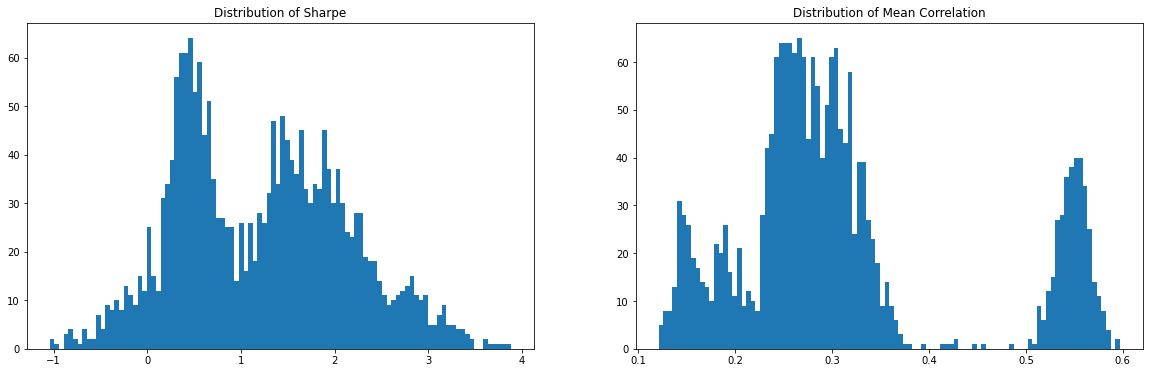

In [6]:
corr_vs_sharpe = np.array(corr_vs_sharpe)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.hist(corr_vs_sharpe[:, 1], bins=100)
plt.title('Distribution of Sharpe')

plt.subplot(1, 2, 2)
plt.hist(corr_vs_sharpe[:, 0], bins=100)
plt.title('Distribution of Mean Correlation')
plt.show()

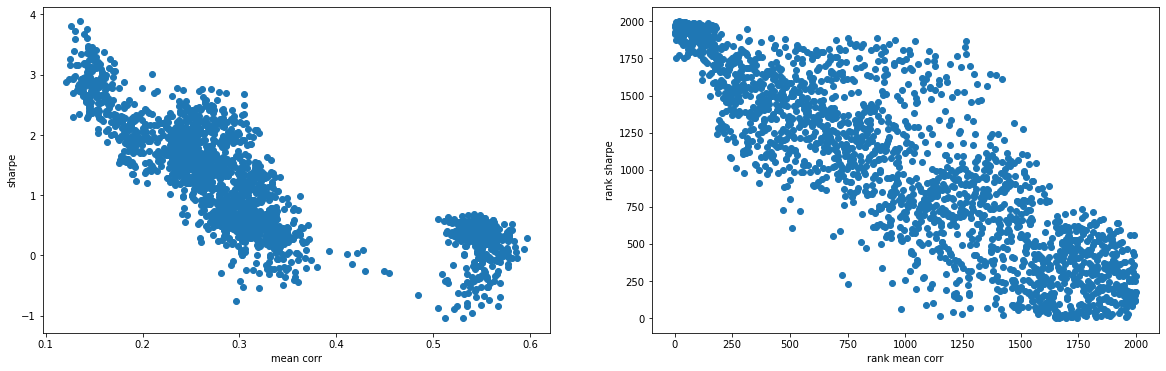

In [7]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.scatter(corr_vs_sharpe[:, 0], corr_vs_sharpe[:, 1])
plt.xlabel('mean corr')
plt.ylabel('sharpe')

plt.subplot(1, 2, 2)
plt.scatter(rankdata(corr_vs_sharpe[:, 0]),
            rankdata(corr_vs_sharpe[:, 1]))
plt.xlabel('rank mean corr')
plt.ylabel('rank sharpe')
plt.show()

In [8]:
len(stressed_mats), len(rally_mats), len(normal_mats)

(28, 416, 1555)

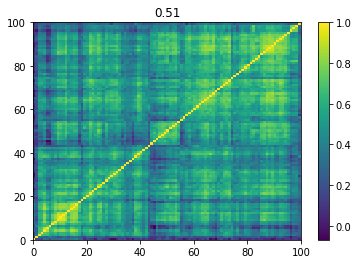

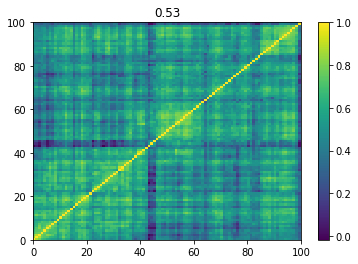

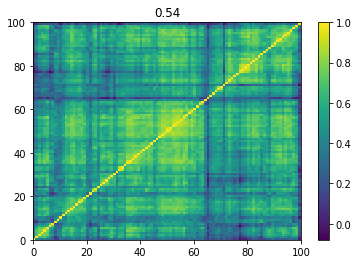

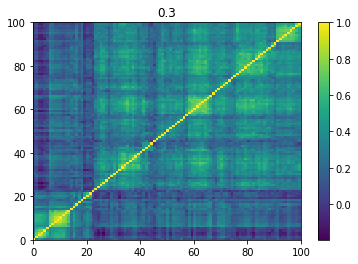

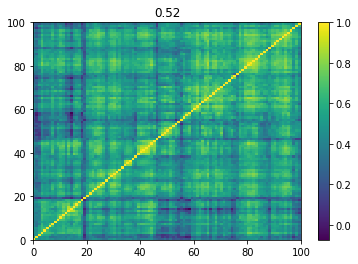

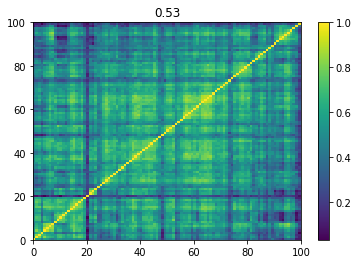

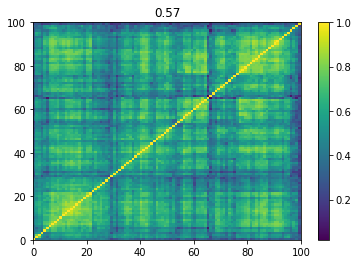

In [9]:
for i, mat in enumerate(stressed_mats):
    plt.pcolormesh(mat)
    plt.colorbar()
    plt.title(round(mat.mean(), 2))
    plt.show()
    
    if i > 5:
        break

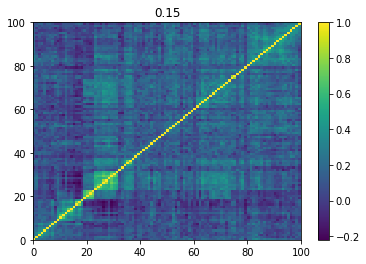

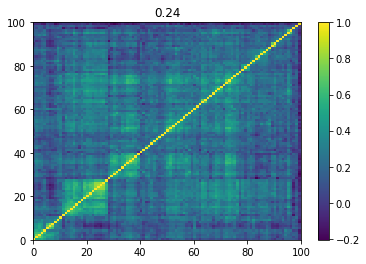

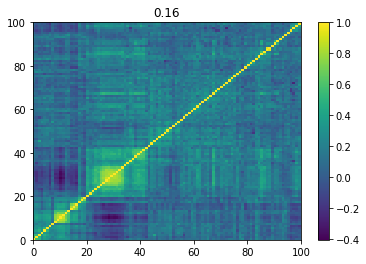

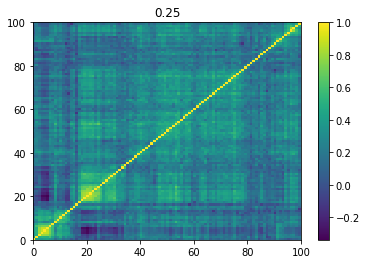

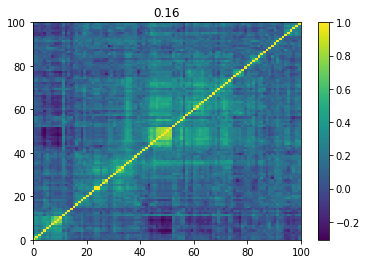

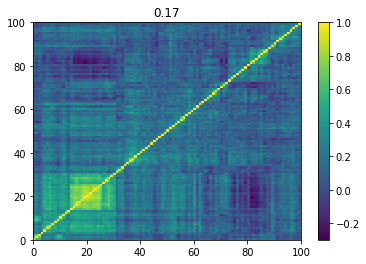

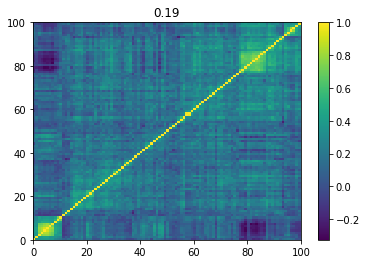

In [10]:
for i, mat in enumerate(rally_mats):
    plt.pcolormesh(mat)
    plt.colorbar()
    plt.title(round(mat.mean(), 2))
    plt.show()
    
    if i > 5:
        break

In [11]:
stressed_corr_coeffs = []
for mat in stressed_mats:
    stressed_corr_coeffs.extend(list(mat[tri_a, tri_b]))

rally_corr_coeffs = []
for mat in rally_mats:
    rally_corr_coeffs.extend(list(mat[tri_a, tri_b]))
    
normal_corr_coeffs = []
for mat in normal_mats:
    normal_corr_coeffs.extend(list(mat[tri_a, tri_b]))

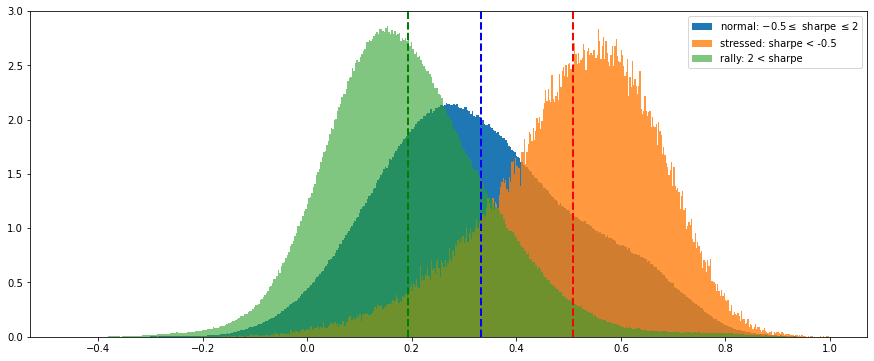

In [12]:
nbins = 500
plt.figure(figsize=(15, 6))
plt.hist(normal_corr_coeffs, bins=nbins, alpha=1,
         label='normal: $-0.5 \leq$ sharpe $\leq 2$',
         density=True, log=False)
plt.axvline(x=np.mean(normal_corr_coeffs), color='b',
            linestyle='dashed', linewidth=2)
plt.hist(stressed_corr_coeffs, bins=nbins, alpha=0.8,
         label='stressed: sharpe < -0.5',
         density=True, log=False)
plt.axvline(x=np.mean(stressed_corr_coeffs), color='r',
            linestyle='dashed', linewidth=2)
plt.hist(rally_corr_coeffs, bins=nbins, alpha=0.6,
         label='rally: 2 < sharpe',
         density=True, log=False)
plt.axvline(x=np.mean(rally_corr_coeffs), color='g',
            linestyle='dashed', linewidth=2)
plt.legend()
plt.show()